In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Build your own `pyannote/video` docker image
```
git clone https://github.com/pyannote/pyannote-video.git
cd pyannote-video
docker build -t pyannote/video .
```

Download sample video and {dlib|openface} models
```
git clone https://github.com/pyannote/pyannote-data.git
```

Launch jupyter notebook
```
docker run -p 80:8888 -v $(pwd)/pyannote-video/scripts:/scripts \
                      -v $(pwd)/pyannote-data:/data \
                      -v $(pwd)/pyannote-video/doc:/notebook \
                      pyannote/video
```

Now visit `http://localhost` to run this notebook locally.

# Shot segmentation

In [2]:
%run /scripts/pyannote-structure.py --help

Video structure

The standard pipeline for is the following:

    shot boundary detection ==> shot threading ==> segmentation into scenes

Usage:
  pyannote-structure.py shot [options] <video> <output.json>
  pyannote-structure.py thread [options] <video> <shot.json> <output.json>
  pyannote-structure.py scene [options] <video> <thread.json> <output.json>
  pyannote-structure.py (-h | --help)
  pyannote-structure.py --version

Options:
  --height=<n_pixels>    Resize video frame to height <n_pixels> [default: 50].
  --window=<n_seconds>   Apply median filtering on <n_seconds> window [default: 2.0].
  --threshold=<value>    Set threshold to <value> [default: 1.0].
  --min-match=<n_match>  Set minimum number of matches to <n_match> [default: 20].
  --lookahead=<n_shots>  Look at up to <n_shots> following shots [default: 24].
  -h --help              Show this screen.
  --version              Show version.
  --verbose              Show progress.


In [3]:
%run /scripts/pyannote-structure.py shot --verbose /data/TheBigBangTheory.mkv /data/TheBigBangTheory.shots.json

752frames [00:31, 24.1frames/s]                     


Detected shot boundaries can be visualized using `pyannote.core` notebook support:

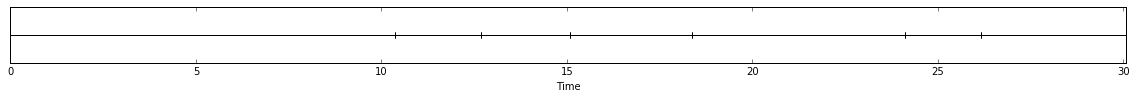

In [6]:
from pyannote.core.json import load_from
shots = load_from('/data/TheBigBangTheory.shots.json')
shots

# Face processing

In [4]:
%run /scripts/pyannote-face.py --help

Face detection and tracking

The standard pipeline is the following

      face tracking => facial landmarks detection => feature extraction

Usage:
  pyannote-face track [options] <video> <shot.json> <output>
  pyannote-face landmarks [options] <video> <model> <tracking> <output>
  pyannote-face features [options] <video> <model> <landmark> <output>
  pyannote-face demo [options] <video> <tracking> <output>
  pyannote-face (-h | --help)
  pyannote-face --version

General options:

  -h --help                 Show this screen.
  --version                 Show version.
  --verbose                 Show processing progress.

Face tracking options (track):

  <video>                   Path to video file.
  <shot.json>               Path to shot segmentation result file.
  <output>                  Path to tracking result file.

  --min-size=<ratio>        Approximate size (in video height ratio) of the
                            smallest face that should be detected. Default is
          

### Face tracking

In [5]:
%run /scripts/pyannote-face.py track --verbose --every=0.5 /data/TheBigBangTheory.mkv \
                                                           /data/TheBigBangTheory.shots.json \
                                                           /data/TheBigBangTheory.track.txt

752frames [00:36, 20.4frames/s]                     


Face tracks can be visualized using `demo` mode:

In [8]:
%run /scripts/pyannote-face.py demo /data/TheBigBangTheory.mkv \
                                    /data/TheBigBangTheory.track.txt \
                                    /data/TheBigBangTheory.track.mp4

[MoviePy] >>>> Building video /data/TheBigBangTheory.track.mp4
[MoviePy] Writing audio in TheBigBangTheory.trackTEMP_MPY_wvf_snd.mp3


100%|██████████| 664/664 [00:01<00:00, 554.27it/s]

[MoviePy] Done.
[MoviePy] Writing video /data/TheBigBangTheory.track.mp4



100%|█████████▉| 752/753 [00:11<00:00, 64.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /data/TheBigBangTheory.track.mp4 



In [9]:
import io
import base64
from IPython.display import HTML
video = io.open('/data/TheBigBangTheory.track.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

### Facial landmarks detection

In [10]:
%run /scripts/pyannote-face.py landmarks --verbose /data/TheBigBangTheory.mkv \
                                                   /data/dlib.face.landmarks.dat \
                                                   /data/TheBigBangTheory.track.txt \
                                                   /data/TheBigBangTheory.landmarks.txt

752frames [00:08, 90.3frames/s]                     


### Openface feature extraction

In [11]:
%run /scripts/pyannote-face.py features --verbose --torch='/root/torch/install/bin/th' \
                                                  /data/TheBigBangTheory.mkv \
                                                  /data/openface.nn4.small2.v1.t7 \
                                                  /data/TheBigBangTheory.landmarks.txt \
                                                  /data/TheBigBangTheory.openface.txt

752frames [03:33, 3.52frames/s]                     


### Face clustering

Once Openface descriptors are extracted, let's apply face track hierarchical agglomerative clustering.  
The distance between two clusters is defined as the euclidean distance between the average Openface descriptors.  
Note that any two co-occurring face tracks (or the clusters they belong to) cannot be merged.

In [28]:
from pyannote.video.face.clustering import FaceClustering
clustering = FaceClustering(threshold=0.8)

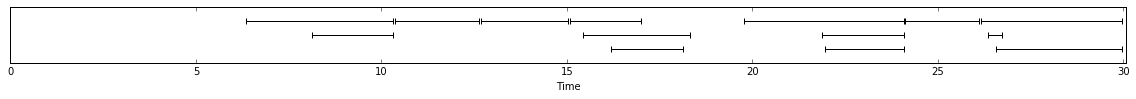

In [29]:
face_tracks, openface = clustering.model.preprocess('/data/TheBigBangTheory.openface.txt')
face_tracks.get_timeline()

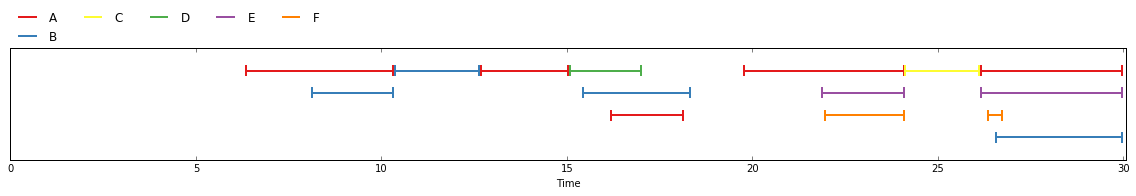

In [30]:
result = clustering(face_tracks, features=openface).anonymize_labels()
result

In [31]:
for _, track_id, cluster in result.itertracks(label=True):
    print track_id, cluster

0 A
1 B
2 B
3 A
4 D
5 B
6 A
7 A
8 E
9 F
10 C
11 A
12 E
13 F
14 B
